<a href="https://colab.research.google.com/github/ConSeanway/BusinessGameRL/blob/master/Demand_Prediction_RL_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.8MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from math import exp
from math import sqrt
from math import log
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
from gym import spaces
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import TRPO
from stable_baselines import results_plotter
import statistics
import random
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines import SAC

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
class CustomEnv(gym.Env):

  def __init__(self, INIT_BALANCE=0, discRate=0.02, maxPeriods=12):
    super(CustomEnv, self).__init__()

    self.capacity = 150
    self.maxPrice = 75

    #defines action space as a continuous element that ranges from 0 to 75
    self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([1, 1]),shape = (2,),dtype=np.float32) 

    # Params we are observing:  time, reward, our price, team 2 price, team 3 price, team 4 price, our units ordered
    self.observation_space = spaces.Box(low=np.array([0, -10000, 0, 0, 0, 0, 0]), high=np.array([6, 10000, 75, 75, 75, 75, self.capacity]), shape=(7,), dtype=np.float32)
    self.stockoutCost = 20
    self.holdingCost = 3

    self.mfgUnitCost = 6

    self.time = 1
    
    #define maximum number of periods to be 1
    self.maxPeriods = 4

    self.reset()

  def step(self, action):

    # Interpret the action array
    agentPrice = action[0] * self.maxPrice
    unitsManufactured = action[1] * self.capacity

    # Compute other team's prices
    otherTeamPrice = 65 - 5 * self.time
    walmartTeamPrice = 15
    panicTeamPrice = 80 - 10 * self.time

    # Create the price array based out of what team's prices we have available
    priceArr = [agentPrice, otherTeamPrice, walmartTeamPrice, panicTeamPrice]

    meanPrice = statistics.mean(priceArr)
    meanDemand = max((75 * len(priceArr)) - (len(priceArr)) * (min(priceArr)), 0)
    totalDemand = meanDemand

    # Allocate demand percentages and determine agent one's demand
    demandPct = []
    demandPct = self.weightedRank(priceArr)

    agentOneDemand = demandPct[0] * totalDemand

    # Revenue is computed as the demand times the price
    revenue = min(agentOneDemand * agentPrice, unitsManufactured * agentPrice)

    # Compute costs
    variableCost = unitsManufactured * self.mfgUnitCost
    invCost = max(self.holdingCost * (unitsManufactured - agentOneDemand), 0) + max(self.stockoutCost * (agentOneDemand - unitsManufactured), 0)
    fixedCost = 1500
    totalCost = variableCost + invCost + fixedCost

    # Reward in this case is profit
    reward = revenue - totalCost    

    self.state = np.array([self.time, reward, agentPrice, otherTeamPrice, walmartTeamPrice, panicTeamPrice, unitsManufactured]).astype(np.float32)

    self.time +=1

    return self.state, reward,self.time > self.maxPeriods,{}
  
  def reset(self):
    self.state = np.array([0, 0, 0, 0, 0, 0, 0]).astype(np.float32)
    self.time = 1 # initial time is zero
    #self.balance = self.INIT_BALANCE # Initial cash balance is 0
    return self.state
    # reward, done, info can't be included



  def weightedRank(self, inputArray):
    # Convert the array so that the minimum value is 1
    direction = -1
    currArray = inputArray

    avg = np.mean(currArray)
    stDev = np.std(currArray)

    # Standardize/normalize values
    for i in range(len(currArray)):
      if stDev > 0:
        currArray[i] = direction * (currArray[i] - avg) / stDev
      else:
        currArray[i] = 0


    # Make sure all entries are shifted to some value greater than 1
    if min(currArray) < 1:
      currArray = [z + (1.1 - min(currArray)) for z in currArray]
      #print("version 1 currAarray",currArray)

    # run the log function to simulate diseconomies of scale
    for i in range(len(currArray)):
      currArray[i] = log(currArray[i])

    # Conver the logged result into a percentage, then return the array
    pctArray = []
    for i in range(len(currArray)):
      #print("marketshare: ",currArray[i] / sum(currArray))
      pctArray.append(currArray[i] / sum(currArray))

    '''
    #Turns percentage into cumulative percentage; then scale the values to range 
    cumuPerArray = []
    cumuValue = 0
    scaleValue = 0
    for j in range(len(currArray)):
      cumuValue = cumuValue+currArray[i]
      scaleValue = cumuValue*self.maxPrice

      cumuPerArray.append(scaleValue)

    #Adjust the values to the lower bound
    if min(currArray)<self.minPrice:
      currArray = [m + self.minPrice-min(currArray) for m in currArray]

    print("end of period")
    '''

    return pctArray

env = CustomEnv()
check_env(env)    

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [0]:

game = CustomEnv()

obs = game.reset()

totalReward = 0

n_steps = 20
for step in range(n_steps):
  print("Step {}".format(step + 1))
  #action = game.action_space.sample()
  priceSet = 1
  unitsMfg = 0
  action = [priceSet, unitsMfg]
  obs, reward, done, info = game.step(action)
  print('obs=', obs, 'reward=', reward, 'action=', action,'done=', done)
  totalReward += reward
  if done:
    print("Goal reached!", "reward=", reward)
    print("Total reward=", totalReward)
    break

Step 1
obs= [ 1.0000000e+00 -1.7075076e+03  7.5000000e+01  6.0000000e+01
  1.5000000e+01  7.0000000e+01  0.0000000e+00] reward= -1707.5075514916584 action= [1, 0] done= False
Step 2
obs= [    2.     -1669.4515    75.        55.        15.        60.
     0.    ] reward= -1669.4514883524384 action= [1, 0] done= False
Step 3
obs= [    3.    -1647.648    75.       50.       15.       50.        0.   ] reward= -1647.6479837525942 action= [1, 0] done= False
Step 4
obs= [    4.     -1635.0586    75.        45.        15.        40.
     0.    ] reward= -1635.0586372656744 action= [1, 0] done= True
Goal reached! reward= -1635.0586372656744
Total reward= -6659.665660862365


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


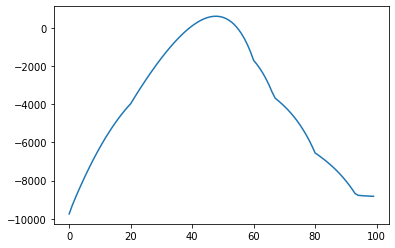

In [0]:
# Price/profit graphing code
game = CustomEnv()

rewardGained = []

for j in np.arange(0, 1, 0.01):

  obs = game.reset()

  totalReward = 0

  n_steps = 20
  for step in range(n_steps):
    price = j
    unitsMfg = 1
    action = [price, unitsMfg]
    obs, reward, done, info = game.step(action)
    #print('obs=', obs, 'reward=', reward, 'action=', action,'done=', done)
    totalReward += reward
    if done:
      #print("Goal reached!", "reward=", reward)
      #print("Total reward=", totalReward)
      rewardGained.append(totalReward)
      break
plt.plot(rewardGained)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


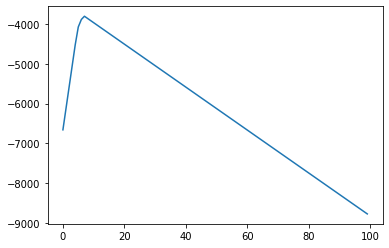

In [0]:
# UnitsManufactured/profit graphing code
game = CustomEnv()

rwGained = []

for i in np.arange(0, 1, 0.01):

  obs = game.reset()

  rTot = 0

  n_steps = 20
  for step in range(n_steps):
    price = 1
    unitsMfg = i
    action = [price, unitsMfg]
    obs, reward, done, info = game.step(action)
    #print('obs=', obs, 'reward=', reward, 'action=', action,'done=', done)
    rTot += reward
    if done:
      #print("Goal reached!", "reward=", reward)
      #print("Total reward=", totalReward)
      rwGained.append(rTot)
      break
plt.plot(rwGained)

In [0]:
game = CustomEnv()

# Create the "model" for our RL
model = TRPO(MlpPolicy, game, verbose=0)

totalRewards = []

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.











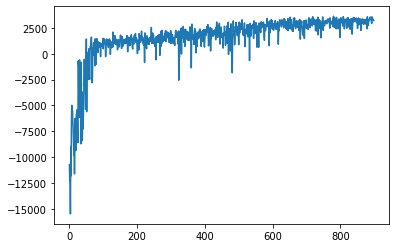

In [132]:
numDataPtsDesired = 100
numTimeSteps = 50


for i in range(numDataPtsDesired):
  # Have the model learn for numTimeSteps more timesteps, and append the number of iterations to our list
  model.learn(total_timesteps=numTimeSteps)

  # Have the model run predictions for a new instance of the game to gather data on performance
  #for samplePoint in range(sampledPoints):
  done = False
  obs = game.reset()

  currRewardTot = 0

  # Generate a prediction and then total up the rewards
  while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = game.step(action)

    currRewardTot += rewards
  
  # Append the mean total reward as our result
  totalRewards.append(currRewardTot)

# Display the total rewards list
#print(totalRewards)
# Plot the rewards
plt.plot(totalRewards)

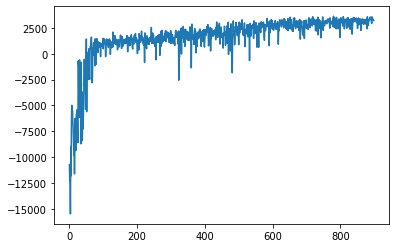

In [133]:
# My lazy way of saving plots that I like temporarily
plt.plot(totalRewards)

In [0]:
#model = TRPO(MlpPolicy, game, verbose=1)
#model.learn(total_timesteps=50000)

In [134]:
# Test the model to see how it performs

dones = False
obs = game.reset()
while not dones:
  action, _states = model.predict(obs)
  obs, rewards, dones, info = game.step(action)
  print(action)
  print(obs)
  print(rewards)

[0.697 0.33 ]
[  1.    515.909  52.257  60.     15.     70.     49.498]
515.9090765548867
[0.537 0.583]
[   2.    1008.947   40.262   55.      15.      60.      87.503]
1008.9472575285467
[0.516 0.594]
[  3.    741.833  38.693  50.     15.     50.     89.153]
741.8331263017235
[0.461 0.499]
[  4.    311.048  34.554  45.     15.     40.     74.841]
311.0478863582996


In [0]:
#game.weightedRank([70, 60, 15, 70])

[0.050690329999932976,
 0.22954492710415925,
 0.6690744128959747,
 0.050690329999932976]

In [0]:
# Test the model to see how it performs

rewRecord = []

dataPts = 250
prices = [[0 for x in range(4)] for y in range(dataPts)]
qtyOrdered = [[0 for x in range(4)] for y in range(dataPts)]


for i in range(dataPts):
  dones = False
  obs = game.reset()
  thisGameReward = 0.0
  counter = 0

  while not dones:
    action, _states = model.predict(obs)

    prices[i][counter] = action[0] * game.maxPrice
    qtyOrdered[i][counter] = action[1] * game.capacity

    obs, rewards, dones, info = game.step(action)
    thisGameReward += rewards
    #print(action)
    #print(obs)
    #print(rewards)
    counter += 1
  rewRecord.append(thisGameReward)
prices = np.array(prices)
qtyOrdered = np.array(qtyOrdered)

Reward mean (sum of all period rewards) is: 3163.5335044456388
Reward stDev is: 388.5070974835021


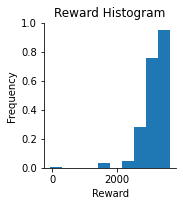

In [136]:
# Create a reward histogram

import seaborn as sns
import pandas as pd

print("Reward mean (sum of all period rewards) is: " + str(statistics.mean(rewRecord)))
print("Reward stDev is: " + str(statistics.stdev(rewRecord)))

ax = sns.pairplot(pd.DataFrame(rewRecord))
ax.set(title="Reward Histogram", xlabel='Reward', ylabel='Frequency')
plt.show()

Mean price for Pd 0: 48.67749971151352
price Standad Deviation for Pd 0: 1.9768503634110908


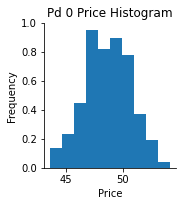

Mean qtyOrdered for Pd 0: 78.16940438747406
qtyOrdered Standad Deviation for Pd 0: 9.12061859885416


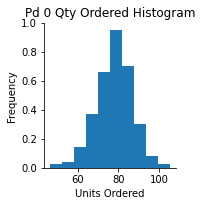

In [137]:
# Pd 0 pricing pairplot
currPeriodPrice = prices[:,0]
print("Mean price for Pd 0: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 0: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 0 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 0 qtyOrdered pairplot
currPdQty = qtyOrdered[:,0]
print("Mean qtyOrdered for Pd 0: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 0: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd 0 Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()

Mean price for Pd 1: 41.57256023883819
price Standad Deviation for Pd 1: 2.2884779157003843


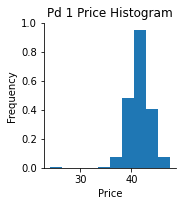

Mean qtyOrdered for Pd 1: 85.66208138465882
qtyOrdered Standad Deviation for Pd 1: 11.286865105294561


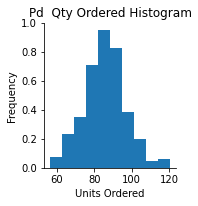

In [138]:
# Pd 1 pricing pairplot
currPeriodPrice = prices[:,1]
print("Mean price for Pd 1: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 1: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 1 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 1 qtyOrdered pairplot
currPdQty = qtyOrdered[:,1]
print("Mean qtyOrdered for Pd 1: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 1: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd  Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()

Mean price for Pd 2: 36.846804794669154
price Standad Deviation for Pd 2: 2.178808107637526


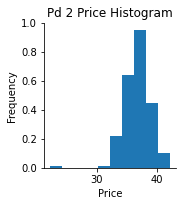

Mean qtyOrdered for Pd 2: 86.74180878996849
qtyOrdered Standad Deviation for Pd 2: 10.621577053802758


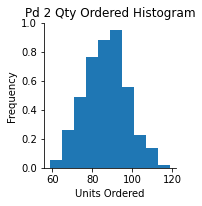

In [139]:
# Pd 2 pricing pairplot
currPeriodPrice = prices[:,2]
print("Mean price for Pd 2: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 2: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 2 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 2 qtyOrdered pairplot
currPdQty = qtyOrdered[:,2]
print("Mean qtyOrdered for Pd 2: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 2: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd 2 Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()

Mean price for Pd 3: 32.87197367995977
price Standad Deviation for Pd 3: 2.44453702577852


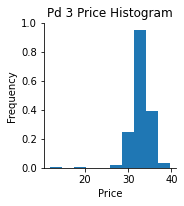

Mean qtyOrdered for Pd 3: 80.89483770132065
qtyOrdered Standad Deviation for Pd 3: 10.78756621176234


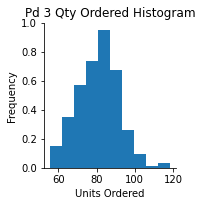

In [140]:
# Pd 3 pricing pairplot
currPeriodPrice = prices[:,3]
print("Mean price for Pd 3: " + str(statistics.mean(currPeriodPrice)))
print("price Standad Deviation for Pd 3: " + str(statistics.stdev(currPeriodPrice)))
ax = sns.pairplot(pd.DataFrame(currPeriodPrice))
ax.set(title="Pd 3 Price Histogram", xlabel='Price', ylabel='Frequency')
plt.show()

# Pd 1 qtyOrdered pairplot
currPdQty = qtyOrdered[:,3]
print("Mean qtyOrdered for Pd 3: " + str(statistics.mean(currPdQty)))
print("qtyOrdered Standad Deviation for Pd 3: " + str(statistics.stdev(currPdQty)))
ax = sns.pairplot(pd.DataFrame(currPdQty))
ax.set(title="Pd 3 Qty Ordered Histogram", xlabel='Units Ordered', ylabel='Frequency')
plt.show()